In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import tensorflow_datasets as tfds

# 데이터 불러오기

In [2]:
# train, test 데이터 불러오기

train_path = './data/train.csv' # 필요에 따라 변경하세요.
test_path = './data/test.csv' # 필요에 따라 변경하세요.
train_normal_data_path = './data/일반대화 합성데이터(GPT-4o, AIhub 참고).csv'

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    return df

train_df = load_data(train_path)
test_df = load_data(test_path)
normal_df = load_data(train_normal_data_path)

In [3]:
# 데이터 확인
train_df.shape, test_df.shape, normal_df.shape

((3950, 3), (500, 2), (1000, 3))

In [4]:
# train data 와 normal 데이터 합치기
def concat_train_normal(train_df, normal_df):
    train_df = pd.concat([train_df, normal_df], ignore_index=True)
    train_df.drop(['idx'], axis=1, inplace=True)
    train_df.reset_index(inplace=True)

    return train_df

train_df = concat_train_normal(train_df, normal_df)
train_df.head()

,index,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
# 클래스 숫자로 변환
def class_encoding(train_df, class_mapping):
    train_df['class_encoded'] = train_df['class'].replace(class_mapping)
    
    return train_df

# 클래스 매핑 딕셔너리 정의
class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

train_df = class_encoding(train_df, class_mapping)

# 변환된 데이터 확인
train_df.shape, train_df.head()


((4950, 4),
    index      class                                       conversation  \
 0      0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...   
 1      1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...   
 2      2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...   
 3      3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...   
 4      4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...   
 
    class_encoded  
 0              0  
 1              0  
 2              3  
 3              1  
 4              1  )

In [6]:
# 중복된 'conversation' 제거
train_df = train_df.drop_duplicates(subset=['conversation'])

# 중복 제거 후 데이터 확인
print(f"중복 제거된 후 데이터 수: {train_df.shape[0]}")

중복 제거된 후 데이터 수: 4846


In [7]:
from sklearn.model_selection import train_test_split

# 1️⃣ 먼저 데이터를 섞기
train_df = train_df.sample(frac=1, random_state=1998).reset_index(drop=True)

# 2️⃣ 60%: 훈련 데이터 분할
train_data, temp_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['class_encoded'])

# 3️⃣ 남은 40% 중 50%를 검증, 50%를 테스트로 나누기 (즉, 20%씩)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['class_encoded'])

# 4️⃣ 결과 확인
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 3876, Validation size: 485, Test size: 485


# 전처리

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 개행 문자("\n")를 공백으로 변환
  sentence = re.sub(r"\n", " ", sentence)
    
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [9]:
conversation = train_data['conversation'].apply(preprocess_sentence)
conversation

1106    거기 누구에요 ! ! ! ! 뭐야 ! ! ! ! 조용히 해 . 왜그러세요 ? . 내...
2124    야 비번 풀어 안 그러면 니 머리통에 구멍 나는 거야 저는 비번 몰라요 . ! ! ...
1972    어이 김대리 어딨는데 . 과장님 담배 때문에 잠깐 밖에요 . 그럼 내가 얘기한 거 ...
4079    너 지갑있지 없는데 만원만줘 없다니까 나 당장급해서그래 빌려주라갚아줄게 너가 갚아준...
1554    야 나 니 차 좀 쓴다 . 안돼 왜 ? 좀 쓴다고 . 너 저번에도 내 차 빌려가서 ...
                              ...                        
3572    영어 강의 듣는 다더니 하루 들었음 . . . 할라 했는데 잘 안되네    개소름 ...
3811    야 . 돈 좀 내놔 싫어 . 내가 돈이 어딨어 . 죽고싶냐 ? 빨리 내놔 . 너 엄...
4683    올만이다 경수야   만원만빌려줘 싫어 몇년만에 이게뭐냐 ? 제발당장 급해서 그래 다...
2963    넌 왜이리 얼굴에 여드름이 많아 ? 나도 그래서 스트레스야 . 여드름이 나이가 몇인...
2670    아니 미국 동물원에 고릴라가 코로나 걸렸대 . . . 뭐에 ? 고릴라가 코로나에 걸...
Name: conversation, Length: 3876, dtype: object

In [10]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation, target_vocab_size=2**13)

In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size
print(VOCAB_SIZE)

8197


In [12]:
# 1998번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(conversation[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [2221, 672, 2409, 55, 2885, 1, 25, 7109, 2, 129, 1745, 822, 2502, 1599, 3561, 5907, 7973, 4500, 5098, 237, 4673, 100, 1, 162, 1095, 721, 1, 74, 71, 4500, 348, 505, 71, 4044, 547, 2, 4669, 23, 3562, 7781, 854, 963, 1, 49, 376, 8178, 8071, 8124, 23, 6771, 55, 43, 3721, 1, 383, 33, 1, 6302, 55, 5236, 1171, 6229, 1175, 3505, 1, 423, 5124, 247, 6988, 1, 3101, 34, 3213, 7778, 7973, 459, 397, 2038, 6012, 74, 104, 5433, 7973, 1478, 183, 3443, 1699, 746, 2423, 2, 654, 39, 179, 2043, 6265, 1, 49, 615, 132, 208, 47, 395, 1345, 225, 703, 1511, 4572, 2078, 1, 5015, 31]


In [13]:
# 원본 확인
conversation[1998].split()

['학생',
 '잠깐',
 '이리로',
 '와봐',
 '.',
 '왜',
 '그러시죠',
 '?',
 '요즘',
 '부모들은',
 '어린',
 '애들한테도',
 '명품',
 '옷을',
 '사준다고',
 '하더니',
 '.',
 '진짜였군',
 '.',
 '제가',
 '무슨',
 '옷을',
 '입든',
 '무슨',
 '상관이에요',
 '?',
 '학생들은',
 '학생답게',
 '다녀야지',
 '.',
 '그',
 '재킷은',
 '오늘부로',
 '내',
 '거다',
 '.',
 '싫어요',
 '.',
 '생일선물로',
 '겨우',
 '받은',
 '옷이란',
 '말이에요',
 '.',
 '일을',
 '복잡하게',
 '만드네',
 '.',
 '험한',
 '꼴',
 '당하고',
 '싶어',
 '?',
 '.',
 '아뇨',
 '그치만',
 '제가',
 '정말',
 '아끼는',
 '옷인데',
 '이번만',
 '봐주시면',
 '안될까요',
 '?',
 '좋아',
 '그럼',
 '인심',
 '썼다',
 '.',
 '그',
 '옷',
 '대신',
 '만원',
 '가져와봐',
 '.',
 '.',
 '엄마한테',
 '문자할게요',
 '.',
 '잠시만요',
 '.']

In [14]:
# 각 데이터의 토큰 개수 세기
temp = list(map(lambda x : len(x.split()), conversation))
temp[:5]

[63, 80, 43, 18, 73]

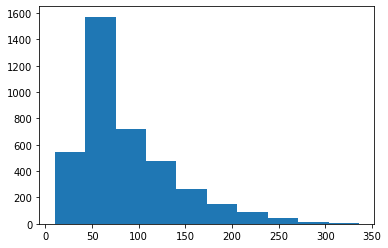

In [15]:
# 각 데이터의 토큰 개수 시각화 - histplot
import matplotlib.pyplot as plt

plt.hist(temp)
plt.show()

In [16]:
print(f'MAX_LENGTH = 200 일때: {np.array([True if x <= 200 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 100 일때: {np.array([True if x <= 100 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 50 일때: {np.array([True if x <= 50 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')

MAX_LENGTH = 200 일때: 95.74 %
MAX_LENGTH = 100 일때: 70.69 %
MAX_LENGTH = 50 일때: 24.38 %


In [17]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 200
print(MAX_LENGTH)

200


In [18]:
# 최대 길이를 초과하는 샘플은 데이터 자르기, 패딩
def tokenize_and_filter(inputs):
  tokenized_inputs = list()
  
  for sentence in inputs:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence = tokenizer.encode(sentence)

    # 최대 길이 200 까지만 데이터셋으로 사용
    if len(sentence) <= MAX_LENGTH:
      tokenized_inputs.append(sentence)
    
    else:
      tokenized_inputs.append(sentence[:MAX_LENGTH])
  
  # 최대 길이 200으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [19]:
conversation = tokenize_and_filter(conversation)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 8197
필터링 후의 대화 샘플 개수: 3876


# 모델링 - transformer 인코딩 모델 밑바닥부터 구현하기

In [20]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 생성하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [21]:
# 인코더만 구성하기
def my_encoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="my_encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Global Average Pooling 적용 (or Max Pooling 가능)
  outputs = tf.keras.layers.GlobalMaxPooling1D()(enc_outputs)

  # 완전연결층
  outputs = tf.keras.layers.Dense(256, activation="relu", name='dense1')(outputs)
#   outputs = tf.keras.layers.Dropout(0.3)(outputs)  # 🔥 드롭아웃 추가 (30%)
  outputs = tf.keras.layers.Dense(128, activation="relu", name='dense2')(outputs)
#   outputs = tf.keras.layers.Dropout(0.3)(outputs)  # 🔥 드롭아웃 추가 (30%)
  outputs = tf.keras.layers.Dense(units=5, activation="softmax", name='outputs')(outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [22]:
# 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = my_encoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "my_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    8423680     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           encoder[0][0]           

In [23]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping & ModelCheckpoint 설정
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint(
    "best_model", monitor='val_loss', save_best_only=True, mode='max', verbose=1, save_format="tf", save_weights_only=True)

callbacks = [early_stopping, model_checkpoint]


In [25]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

def get_dataset(data):
    conversation = data['conversation'].apply(preprocess_sentence)
    conversation = tokenize_and_filter(conversation)

    dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': conversation},  # 입력 데이터
    {'outputs': data['class_encoded'].values}  # 출력 데이터 (라벨)
    ))
    
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = get_dataset(train_data)
val_dataset = get_dataset(val_data)
test_dataset = get_dataset(test_data)

Epoch 1/100
61/61 [==============================] - 41s 456ms/step - loss: 1.5512 - accuracy: 0.2740 - val_loss: 1.4209 - val_accuracy: 0.3876

Epoch 00001: val_loss improved from -inf to 1.42089, saving model to best_model
Epoch 2/100
61/61 [==============================] - 25s 418ms/step - loss: 1.2380 - accuracy: 0.3991 - val_loss: 1.2091 - val_accuracy: 0.4289

Epoch 00002: val_loss did not improve from 1.42089
Epoch 3/100
61/61 [==============================] - 26s 420ms/step - loss: 1.1135 - accuracy: 0.4631 - val_loss: 1.1914 - val_accuracy: 0.4041

Epoch 00003: val_loss did not improve from 1.42089
Epoch 4/100
61/61 [==============================] - 26s 424ms/step - loss: 0.9615 - accuracy: 0.5712 - val_loss: 0.9072 - val_accuracy: 0.5588

Epoch 00004: val_loss did not improve from 1.42089
Epoch 5/100
61/61 [==============================] - 26s 426ms/step - loss: 0.7456 - accuracy: 0.6695 - val_loss: 0.7561 - val_accuracy: 0.6557

Epoch 00005: val_loss did not improve from

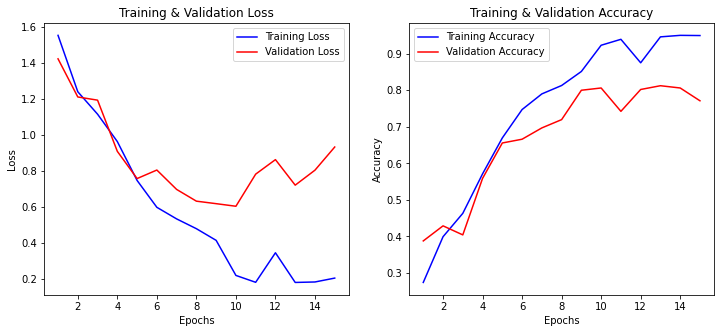

In [27]:
import matplotlib.pyplot as plt

# 모델 학습 실행 (history 저장)
EPOCHS = 100
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks
)

# 학습 결과(history) 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('acc'))  # 'accuracy' 또는 'acc' 키 확인
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))  # 'val_accuracy' 또는 'val_acc' 키 확인

# 에포크 값 생성
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [28]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_train = []
y_train = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in train_dataset:
    X_train.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_train.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

pd.value_counts(y_train)


3    809
4    800
1    778
2    776
0    713
dtype: int64

In [29]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_val = []
y_val = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in val_dataset:
    X_val.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_val.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_val = np.array(X_val)
y_val = np.array(y_val)

pd.value_counts(y_val)


3    101
4    100
1     98
2     97
0     89
dtype: int64

In [30]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

pd.value_counts(y_test)


3    101
4    100
1     97
2     97
0     90
dtype: int64

In [31]:
# X 데이터 합치기
temp = np.concatenate([X_train, X_val, X_test], axis=0)
temp.shape

(4846, 200)

In [32]:
# X 데이터 중복값 확인(데이터 누출 확인)
np.unique(temp, axis=0).shape

(4845, 200)

# Test dataset으로 확인하기

In [33]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(train_dataset)

61/61 [==============================] - 9s 155ms/step - loss: 0.1467 - accuracy: 0.9745


[0.14667412638664246, 0.9744582176208496]

In [34]:
# 모델 평가 (validation_dataset을 사용)
model.evaluate(val_dataset)

8/8 [==============================] - 1s 148ms/step - loss: 0.6023 - accuracy: 0.8062


[0.6023104786872864, 0.8061855435371399]

In [35]:
# 모델 평가 (test_dataset을 사용)
model.evaluate(test_dataset)

8/8 [==============================] - 1s 149ms/step - loss: 0.5155 - accuracy: 0.8247


[0.5155377388000488, 0.8247422575950623]

In [36]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (485, 200)
y_test shape: (485,)


In [37]:
def get_pred(X_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    
    return y_pred

y_pred = get_pred(X_test)
y_pred[:5]

array([1, 3, 0, 1, 0])

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7234    0.7556    0.7391        90
           1     0.8587    0.8144    0.8360        97
           2     0.9390    0.7938    0.8603        97
           3     0.6667    0.7525    0.7070       101
           4     0.9709    1.0000    0.9852       100

    accuracy                         0.8247       485
   macro avg     0.8317    0.8233    0.8255       485
weighted avg     0.8328    0.8247    0.8268       485



# 추론 및 Submission 저장

In [39]:
def make_submission_df(model, test_df):
    test_conversation = test_df['text'].apply(preprocess_sentence)
    test_conversation = tokenize_and_filter(test_conversation)
    
    y_pred = get_pred(test_conversation)
    
    test_df['target'] = y_pred
    test_df.drop(['text'], axis=1, inplace=True)
    
    return test_df

test_df = make_submission_df(model, test_df)
test_df.to_csv('my_submission.csv', index=False)
test_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,0
